In [196]:
import glob, matplotlib, re, math, pandas
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from ccMET_selections import selections

randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [197]:
allSamps = pandas.read_hdf('ccMET.h5')

In [198]:
presel = selections['presel_0lep_1cjet20'].replace('*', ' & ').replace('||', ' | ').replace('(', '(allSamps.').replace('allSamps.(', '(')
print(presel)
#print(sorted(branches))
myPresel = (allSamps.passTightCleanDFFlag==1) & (allSamps.nj_good>=2) & ((allSamps.tcMeTCategory==1) | (allSamps.tcMeTCategory<0)) & (allSamps.pT_1jet>250) & (allSamps.num_bjets==0) & ((allSamps.GenFiltMET<100 ) |  (allSamps.RunNumber!=410470)) & (allSamps.nsignalLep==0) & (allSamps.nbaselineLep==0) & (allSamps.eT_miss>250) & (allSamps.minDPhi_4jetMET>0.4) & (allSamps.num_cjets20>=2)

(allSamps.passTightCleanDFFlag==1) & (allSamps.nj_good>=2) & ((allSamps.tcMeTCategory==1) | (allSamps.tcMeTCategory<0)) & (allSamps.pT_1jet>250) & (allSamps.num_bjets==0) & ((allSamps.GenFiltMET<100 ) |  (allSamps.RunNumber!=410470)) & (allSamps.METTrigPassed) & (allSamps.nsignalLep==0) & (allSamps.nbaselineLep==0) & (allSamps.eT_miss>250) & (allSamps.minDPhi_4jetMET>0.4) & (allSamps.num_cjets20>=1)


In [199]:
rawDataPresel = allSamps[eval(presel)].copy()
#rawDataPresel = allSamps[myPresel].copy()
sampSizes = {}
sampYields = {}

for sampName in sorted(pandas.unique(rawDataPresel.sampName)):
    sampIndex = rawDataPresel['sampName']==sampName
    sampYield = rawDataPresel[sampIndex].weight.sum()
    if sampYield == 0:
        print("Dropping", sampName)
        rawDataPresel.drop(sampIndex)
    sampSizes[sampName] = rawDataPresel[sampIndex].shape[0]
    sampYields[sampName] = sampYield
    print(sampName, round(sampYield,1), sampIndex.sum())
    
maxYieldKey = max(sampYields, key=lambda k: sampYields[k])
tempDFs = []
goodSamps = pandas.unique(rawDataPresel.sampName)
for sampName in sampYields:
    sampIndex = rawDataPresel['sampName']==sampName
    rawDataPresel.loc[sampIndex, 'clus_weight'] = rawDataPresel.loc[sampIndex, 'weight']*(sampYields[maxYieldKey]/sampYields[sampName])
    #print(rawDataPresel[sampIndex].clus_weight.sum())

bkg 146375.0 208763
sig_1000_1 162.7 442
sig_1000_100 156.5 424
sig_1000_200 157.5 427
sig_1000_300 170.8 464
sig_1000_400 155.5 429
sig_1000_500 156.6 433
sig_1000_600 150.0 418
sig_1000_700 118.6 339
sig_1050_150 112.7 441
sig_1050_250 113.0 437
sig_1050_50 121.7 472
sig_1100_1 75.6 417
sig_1100_100 75.3 411
sig_1100_200 81.5 447


sig_1100_300 77.1 423
sig_1100_400 76.7 419
sig_1100_500 87.1 477
sig_1100_600 83.2 465
sig_1100_700 69.5 392
sig_1200_1 39.2 422
sig_1200_100 38.0 409
sig_1200_200 39.0 426
sig_1200_300 38.7 419
sig_1200_400 39.9 431
sig_1200_500 46.5 499
sig_1200_600 38.7 422
sig_1300_1 20.7 430
sig_1300_100 18.5 375
sig_1300_200 17.6 358


sig_1300_300 21.8 447
sig_1300_400 18.9 394
sig_1300_500 20.7 430
sig_400_225 6944.8 423
sig_500_1 8780.7 1434
sig_500_325 2524.6 525
sig_550_375 1548.6 1099
sig_600_1 3852.6 1817
sig_600_300 2505.8 1228
sig_600_425 1000.4 597
sig_650_350 1500.2 1201
sig_650_475 624.0 593
sig_700_1 1777.4 1300
sig_700_100 1714.9 1661
sig_700_200 1675.1 1235


sig_700_300 1432.7 1773
sig_700_400 1058.4 2688
sig_700_525 403.3 483
sig_750_250 1080.9 1229
sig_750_350 944.2 726
sig_750_450 686.1 811
sig_750_575 274.8 254
sig_800_1 748.8 860
sig_800_100 688.6 792
sig_800_200 736.5 841
sig_800_300 690.8 798
sig_800_400 634.5 746
sig_800_500 501.7 605
sig_800_625 195.0 276
sig_850_150 506.3 436


sig_850_250 506.0 440
sig_850_350 464.2 407
sig_850_450 461.7 405
sig_850_50 519.1 447
sig_900_1 335.0 4292
sig_900_100 341.5 438
sig_900_200 352.2 451
sig_900_300 327.1 419
sig_900_400 314.2 409
sig_900_500 279.5 367
sig_900_600 206.0 278
sig_950_150 254.2 473
sig_950_250 240.0 450
sig_950_350 223.6 423
sig_950_50 214.3 400


In [200]:
# Tried adding more variables but this seems to cause a degradation in performance: only one signal cluster is found.
# (two are expected based on the manually designed signal regions).
trainBranches = ['MTcMin20', 'metsigST', 'm_cc20', 'pT_1jet', 'pT_2jet']#, 'pT_1cjet', 'pT_2cjet']# 'eT_miss']
#trainBranches = ['MTcMin20', 'metsigST', 'm_cc20', 'pT_1cjet', 'pT_2cjet']#, 'eT_miss']
varListStr = '_'.join(trainBranches)
print(varListStr)

MTcMin20_metsigST_m_cc20_pT_1jet_pT_2jet


In [201]:
scaledData = rawDataPresel.copy(deep=True)
scalers = {}
for column in trainBranches:
    print(column)
    scalers[column] = MinMaxScaler()
    scaledData[[column]] = scalers[column].fit_transform(scaledData[[column]])
clusteringData = scaledData[trainBranches]

MTcMin20
metsigST
m_cc20
pT_1jet
pT_2jet


In [210]:
twoSigs = scaledData[(scaledData.sampName=='sig_1300_1') | ( scaledData.sampName=='sig_550_375')]
bkgs = scaledData[(scaledData.sampName=='bkg')].sample(1000)
# aeData = bkgs[trainBranches]
# weights = bkgs['clus_weight']
aeData = twoSigs[trainBranches]
tempWeights = twoSigs['clus_weight']
print(aeData.shape)

(1529, 5)


In [211]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(randomState)

In [251]:
def weighted_mse_loss(inputs: torch.Tensor, targets: torch.Tensor, weights: torch.Tensor):
    perSampleMSE = ((inputs - targets) ** 2).mean(dim=1)
    loss = weights * perSampleMSE
    return loss.mean()

latent_dim = 2
learning_rate = 1e-4
class autoencoder(nn.Module):
    def __init__(self, num_features: int, latent_dim: int) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, latent_dim),
            # It would be nice to have control over the bounds of latent space and it would
            # be nice to encourage separation in the latent space for clustering.
            # Will check this out later.
            #nn.Sigmoid()
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, num_features),
            nn.Sigmoid()
        )

        self.criterion = weighted_mse_loss
        #self.criterion = nn.MSELoss()
        #self.criterion = nn.CrossEntropyLoss()

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
        x = self.encoder(inputs)
        out = self.decoder(x)
        loss = self.criterion(out, targets, weights)
        #loss = self.criterion(out, targets)
        return loss, out


In [252]:
testTrainFrac = 0.5
nEvents=aeData.shape[0]
msk = np.random.choice(nEvents, int(nEvents*testTrainFrac), replace=False)
xTrain = aeData.to_numpy()[msk]
xTest = aeData.to_numpy()[~msk]
trainWeights = torch.Tensor(tempWeights.to_numpy()[msk])
testWeights = torch.Tensor(tempWeights.to_numpy()[~msk])
# trainWeights = torch.ones(msk.shape[0])
# testWeights = torch.ones((~msk).shape[0])
if torch.cuda.is_available():
    trainWeights = trainWeights.cuda()
    testWeights = testWeights.cuda()

batch_size = 32
trainDataset = TensorDataset(torch.Tensor(xTrain),torch.Tensor(xTrain), trainWeights) # create your datset
testDataset = TensorDataset(torch.Tensor(xTest), torch.Tensor(xTest), testWeights) # create your datset
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size)
testDataLoader = DataLoader(testDataset, batch_size=batch_size) 

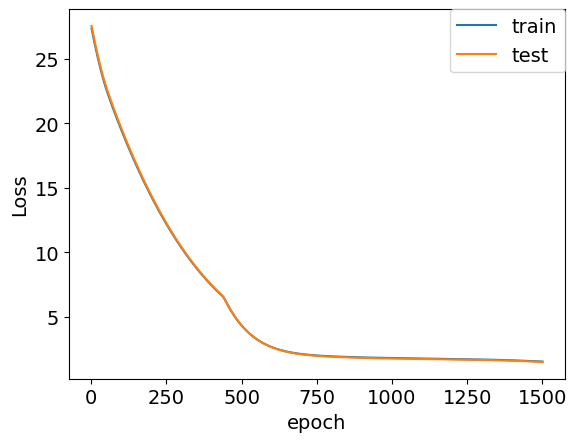

In [253]:
num_epochs = 1500
history = {'loss':[[],[]], 'val_loss':[[],[]]}
verbose = False
model = autoencoder(len(trainBranches), 2)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    total_loss = 0
    for data, labels, weights in trainDataLoader:
        if torch.cuda.is_available():
            data, labels, weights = data.cuda(), labels.cuda(), weights.cuda()
        # ===================forward=====================
        model.train()
        train_loss, output = model(data,labels,weights)
        # labels is the same as data for an autoencoder but we may as well keep
        # things the same as a normal NN. The weights are useful for grouping background
        # into one class (even though it consists of W+jets, Z+jets, etc).
        #train_loss = (train_loss*trainWeights).mean()
        #train_loss = criterion(output, labels)
        # ===================backward====================
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        total_loss+=train_loss.item()
    # ===================log========================
    num_batches = len(trainDataLoader)
    history['loss'][0].append(epoch+1)
    history['loss'][1].append(total_loss/num_batches)

    total_val_loss = 0
    for data, labels, weights in testDataLoader:
        if torch.cuda.is_available():
            data, labels, weights = data.cuda(), labels.cuda(), weights.cuda()
        model.eval()
        with torch.no_grad():
            val_loss, output = model(data,labels, weights)
            #val_loss = (val_loss*testWeights).mean()
            #val_loss = criterion(output,labels)
            total_val_loss += val_loss.item()
    num_batches = len(testDataLoader)
    history['val_loss'][0].append(epoch+1)
    history['val_loss'][1].append(total_val_loss/num_batches)

    if verbose:
        print('epoch [{}/{}], train loss: {:.4f}, test loss:{:.4f}'
              .format(epoch + 1, num_epochs, loss.item(), val_loss.item()))
a = model.eval()
fig, ax = plt.subplots()
plt.plot(history['loss'][0], history['loss'][1])
plt.plot(history['val_loss'][0], history['val_loss'][1])
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
leg = plt.legend(['train', 'test'], loc=0, borderaxespad=0.)
plt.savefig('loss.pdf', bbox_inches='tight')

In [254]:
encoded = {}
decoded = {}
for sampName in sorted(sorted(pandas.unique(twoSigs.sampName))):
    tempData = torch.Tensor(twoSigs[twoSigs.sampName==sampName][trainBranches].to_numpy())
    if torch.cuda.is_available():
            tempData = tempData.cuda()
    encoded[sampName] = model.encoder(tempData)
    decoded[sampName] = model.decoder(encoded[sampName]).cpu().detach().numpy()

0.0 0.05366774201393128


<ipython-input-255-1f60cb216bab>:19: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  a = plt.hist2d(totalEncodedDist[:,0], totalEncodedDist[:,1], bins=bins2d,)


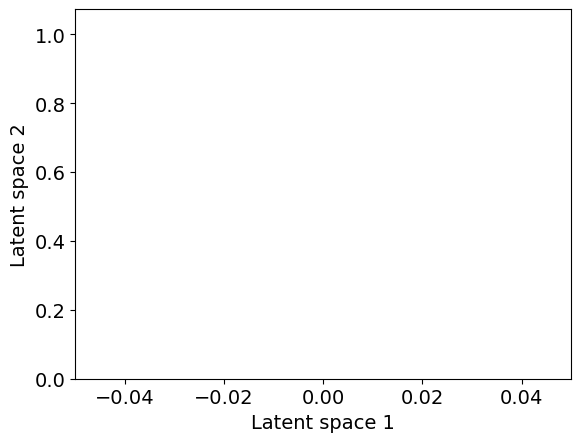

In [255]:
# This shows the latent spacce distributions for the two signals. Essentially we have trained a unsupervised
# classifier since labels were not given to the NN. The latent space is overly simple here (1D).
# We can applying clustering to this latent space and avoid high dimensionality and essentially
# summarize low-level variables. A variational auto-encoder would make these nice Gaussians at which point
# we may be able to use model-based clustering (k-means will also work).
fig, ax = plt.subplots()
colors=['k','r']
sigData = torch.Tensor(twoSigs[trainBranches].to_numpy())
if torch.cuda.is_available():
    sigData = sigData.cuda()
totalEncodedDist = model.encoder(sigData).cpu().detach().numpy()
xMin, yMin = np.min(totalEncodedDist, axis=0)
xMax, yMax = np.max(totalEncodedDist, axis=0)
nBins = 20
dX = (xMax-xMin)/nBins
dY = (yMax-yMin)/nBins
print(dX, dY)
bins2d = [[xMin+i*dX for i in range(nBins+1)], [yMin+i*dY for i in range(nBins+1)]]
a = plt.hist2d(totalEncodedDist[:,0], totalEncodedDist[:,1], bins=bins2d,)
ax.set_xlabel('Latent space 1')
ax.set_ylabel('Latent space 2')
plt.savefig(f'latentSpace.pdf', bbox_inches='tight')
plt.savefig(f'latentSpace.svg', bbox_inches='tight')
plt.savefig(f'latentSpace.png', bbox_inches='tight')

0.0 2.0674849


0.0 1.5400985


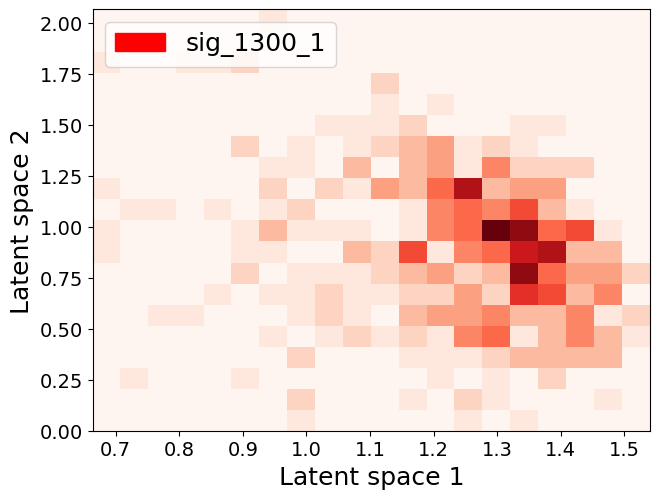

In [195]:
colorMaps = [plt.cm.Reds, plt.cm.Blues]#, plt.cm.Greys]
colors = ['r', 'b']
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
fontsize=8

for color, cmap, sampLabel in zip(colors, colorMaps, sorted(encoded.keys())):
    fig, ax = plt.subplots()
    plotDist = encoded[sampLabel].cpu().detach().numpy()
    print(np.min(plotDist), np.max(plotDist))
    plt.hist2d(plotDist[:,0], plotDist[:,1], bins=bins2d, cmap=cmap, label=sampLabel)#, weights=sampData.weight)
    #plt.contour(xx, yy, z, levels=3, colors='g', linewidths=[3])
    #cluster1Text = ax.text(0.15, 0.05, 'Cluster 1', ha="center", va="center", color=sampColors[2], fontsize=20)
    #cluster2Text = ax.text(0.8, 0.05, 'Cluster 2', ha="center", va="center", color=sampColors[1], fontsize=20)
    #cluster3Text = ax.text(0.15, 0.8, 'Cluster 3', ha="center", va="center", color=sampColors[0], fontsize=20)
    legHandles = [mpatches.Patch(color=color, label=sampLabel)]

    #ax.set_ylim(0, 1)
    #ax.set_xlim(0, 1)
    fontsize=18
    ax.set_xlabel('Latent space 1', fontsize=fontsize)
    ax.set_ylabel('Latent space 2', fontsize=fontsize)
    ax.legend(ncol=1, handles=legHandles, fontsize=fontsize, loc=2)
    plt.tight_layout(pad=0.0)
    plt.margins(0,0)
    plt.savefig(f"latentSpace_{sampLabel}_2DHist.svg",bbox_inches='tight', pad_inches=0)
    plt.savefig(f"latentSpace_{sampLabel}_2DHist.pdf",bbox_inches='tight', pad_inches=0)